# Vision Transformer实现军用车识别
该项目可以实现判断货车是否是军用车辆，能够帮助门岗进行车辆检查。

## Vision Transformer（ViT）简介

近些年，随着基于自注意（Self-Attention）结构的模型的发展，特别是Transformer模型的提出，极大地促进了自然语言处理模型的发展。由于Transformer的计算效率和可扩展性，它已经能够训练具有超过100B参数的空前规模的模型。

ViT则是自然语言处理和计算机视觉两个领域的融合结晶。在不依赖卷积操作的情况下，依然可以在图像分类任务上达到很好的效果。

### 模型结构

ViT模型的主体结构是基于Transformer模型的Encoder部分（部分结构顺序有调整，如：Normalization的位置与标准Transformer不同），其结构图[1]如下：

![vit-architecture](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/tutorials/source_zh_cn/cv/images/vit_architecture.png)

### 模型特点

ViT模型主要应用于图像分类领域。因此，其模型结构相较于传统的Transformer有以下几个特点：

1. 数据集的原图像被划分为多个patch（图像块）后，将二维patch（不考虑channel）转换为一维向量，再加上类别向量与位置向量作为模型输入。
2. 模型主体的Block结构是基于Transformer的Encoder结构，但是调整了Normalization的位置，其中，最主要的结构依然是Multi-head Attention结构。
3. 模型在Blocks堆叠后接全连接层，接受类别向量的输出作为输入并用于分类。通常情况下，我们将最后的全连接层称为Head，Transformer Encoder部分为backbone。

下面将通过代码实例来详细解释基于ViT实现军车识别任务。

> 注意，本教程在CPU上运行时间过长，不建议使用CPU运行。

## 环境准备与数据读取

开始实验之前，请确保本地已经安装了Python环境并安装了MindSpore。

该数据集上传到了魔乐社区，可以通过git下载，首先需要初始化下git-lfs。

运行第一段代码时会自动下载并解压，请确保你的数据集路径如以下结构。

```text
./military/dataset/
                ├── train/
                └── val/
```

In [1]:
%%capture captured_output
# 实验环境已经预装了mindspore==2.5.0，如需更换mindspore版本，可更改下面 MINDSPORE_VERSION 变量
!pip uninstall mindspore -y
%env MINDSPORE_VERSION=2.5.0
!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/${MINDSPORE_VERSION}/MindSpore/unified/aarch64/mindspore-${MINDSPORE_VERSION}-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# 查看当前 mindspore 版本
!pip show mindspore

Name: mindspore
Version: 2.5.0
Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.
Home-page: https://www.mindspore.cn
Author: The MindSpore Authors
Author-email: contact@mindspore.cn
License: Apache 2.0
Location: /home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages
Requires: asttokens, astunparse, dill, numpy, packaging, pillow, protobuf, psutil, safetensors, scipy
Required-by: 


In [25]:
!git lfs install
!git clone https://modelers.cn/xsir/military.git
!unzip -q military/dataset.zip -d ./military

Git LFS initialized.
正克隆到 'military'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 2), reused 0 (delta 0), pack-reused 0
接收对象中: 100% (10/10), 完成.
处理 delta 中: 100% (2/2), 完成.


In [3]:
import os

import mindspore as ms
from mindspore.dataset import ImageFolderDataset
import mindspore.dataset.vision as transforms


data_path = './military/dataset/'
mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
std = [0.229 * 255, 0.224 * 255, 0.225 * 255]

dataset_train = ImageFolderDataset(os.path.join(data_path, "train"), shuffle=True)

trans_train = [
    transforms.RandomCropDecodeResize(size=224,
                                      scale=(0.08, 1.0),
                                      ratio=(0.75, 1.333)),
    transforms.RandomHorizontalFlip(prob=0.5),
    transforms.Normalize(mean=mean, std=std),
    transforms.HWC2CHW()
]

dataset_train = dataset_train.map(operations=trans_train, input_columns=["image"])
dataset_train = dataset_train.batch(batch_size=16, drop_remainder=True)

/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## 模型解析

下面将通过代码来细致剖析ViT模型的内部结构。

### Transformer基本原理

Transformer模型源于2017年的一篇文章[2]。在这篇文章中提出的基于Attention机制的编码器-解码器型结构在自然语言处理领域获得了巨大的成功。模型结构如下图所示：

![transformer-architecture](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/tutorials/source_zh_cn/cv/images/transformer_architecture.png)

其主要结构为多个Encoder和Decoder模块所组成，其中Encoder和Decoder的详细结构如下图[2]所示：

![encoder-decoder](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/tutorials/source_zh_cn/cv/images/encoder_decoder.png)

Encoder与Decoder由许多结构组成，如：多头注意力（Multi-Head Attention）层，Feed Forward层，Normaliztion层，甚至残差连接（Residual Connection，图中的“Add”）。不过，其中最重要的结构是多头注意力（Multi-Head Attention）结构，该结构基于自注意力（Self-Attention）机制，是多个Self-Attention的并行组成。

所以，理解了Self-Attention就抓住了Transformer的核心。

#### Attention模块

以下是Self-Attention的解释，其核心内容是为输入向量的每个单词学习一个权重。通过给定一个任务相关的查询向量Query向量，计算Query和各个Key的相似性或者相关性得到注意力分布，即得到每个Key对应Value的权重系数，然后对Value进行加权求和得到最终的Attention数值。

在Self-Attention中：

1. 最初的输入向量首先会经过Embedding层映射成Q（Query），K（Key），V（Value）三个向量，由于是并行操作，所以代码中是映射成为dim x 3的向量然后进行分割，换言之，如果你的输入向量为一个向量序列（$x_1$，$x_2$，$x_3$），其中的$x_1$，$x_2$，$x_3$都是一维向量，那么每一个一维向量都会经过Embedding层映射出Q，K，V三个向量，只是Embedding矩阵不同，矩阵参数也是通过学习得到的。**这里大家可以认为，Q，K，V三个矩阵是发现向量之间关联信息的一种手段，需要经过学习得到，至于为什么是Q，K，V三个，主要是因为需要两个向量点乘以获得权重，又需要另一个向量来承载权重向加的结果，所以，最少需要3个矩阵。**

$$
\begin{cases}
q_i = W_q \cdot x_i & \\
k_i = W_k \cdot x_i,\hspace{1em} &i = 1,2,3 \ldots \\
v_i = W_v \cdot x_i &
\end{cases}
\tag{1}
$$

![self-attention1](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/tutorials/source_zh_cn/cv/images/self_attention_1.png)

2. 自注意力机制的自注意主要体现在它的Q，K，V都来源于其自身，也就是该过程是在提取输入的不同顺序的向量的联系与特征，最终通过不同顺序向量之间的联系紧密性（Q与K乘积经过Softmax的结果）来表现出来。**Q，K，V得到后就需要获取向量间权重，需要对Q和K进行点乘并除以维度的平方根，对所有向量的结果进行Softmax处理，通过公式(2)的操作，我们获得了向量之间的关系权重。**

$$
\begin{cases}
a_{1,1} = q_1 \cdot k_1 / \sqrt d \\
a_{1,2} = q_1 \cdot k_2 / \sqrt d \\
a_{1,3} = q_1 \cdot k_3 / \sqrt d
\end{cases}
\tag{2}
$$

![self-attention3](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/tutorials/source_zh_cn/cv/images/self_attention_3.png)

$$ Softmax: \hat a_{1,i} = exp(a_{1,i}) / \sum_j exp(a_{1,j}),\hspace{1em} j = 1,2,3 \ldots \tag{3}$$

![self-attention2](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/tutorials/source_zh_cn/cv/images/self_attention_2.png)

3. 其最终输出则是通过V这个映射后的向量与Q，K经过Softmax结果进行weight sum获得，这个过程可以理解为在全局上进行自注意表示。**每一组Q，K，V最后都有一个V输出，这是Self-Attention得到的最终结果，是当前向量在结合了它与其他向量关联权重后得到的结果。**

$$
b_1 = \sum_i \hat a_{1,i}v_i,\hspace{1em} i = 1,2,3...
\tag{4}
$$

通过下图可以整体把握Self-Attention的全部过程。

![self-attention](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/tutorials/source_zh_cn/cv/images/self_attention_process.png)

多头注意力机制就是将原本self-Attention处理的向量分割为多个Head进行处理，这一点也可以从代码中体现，这也是attention结构可以进行并行加速的一个方面。

总结来说，多头注意力机制在保持参数总量不变的情况下，将同样的query, key和value映射到原来的高维空间（Q,K,V）的不同子空间(Q_0,K_0,V_0)中进行自注意力的计算，最后再合并不同子空间中的注意力信息。

所以，对于同一个输入向量，多个注意力机制可以同时对其进行处理，即利用并行计算加速处理过程，又在处理的时候更充分的分析和利用了向量特征。下图展示了多头注意力机制，其并行能力的主要体现在下图中的$a_1$和$a_2$是同一个向量进行分割获得的。

![multi-head-attention](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/tutorials/source_zh_cn/cv/images/multi_head_attention.png)

以下是Multi-Head Attention代码，结合上文的解释，代码清晰的展现了这一过程。

In [4]:
from mindspore import nn, ops


class Attention(nn.Cell):
    def __init__(self,
                 dim: int,
                 num_heads: int = 8,
                 keep_prob: float = 1.0,
                 attention_keep_prob: float = 1.0):
        super(Attention, self).__init__()

        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = ms.Tensor(head_dim ** -0.5)

        self.qkv = nn.Dense(dim, dim * 3)
        self.attn_drop = nn.Dropout(p=1.0-attention_keep_prob)
        self.out = nn.Dense(dim, dim)
        self.out_drop = nn.Dropout(p=1.0-keep_prob)
        self.attn_matmul_v = ops.BatchMatMul()
        self.q_matmul_k = ops.BatchMatMul(transpose_b=True)
        self.softmax = nn.Softmax(axis=-1)

    def construct(self, x):
        """Attention construct."""
        b, n, c = x.shape
        qkv = self.qkv(x)
        qkv = ops.reshape(qkv, (b, n, 3, self.num_heads, c // self.num_heads))
        qkv = ops.transpose(qkv, (2, 0, 3, 1, 4))
        q, k, v = ops.unstack(qkv, axis=0)
        attn = self.q_matmul_k(q, k)
        attn = ops.mul(attn, self.scale)
        attn = self.softmax(attn)
        attn = self.attn_drop(attn)
        out = self.attn_matmul_v(attn, v)
        out = ops.transpose(out, (0, 2, 1, 3))
        out = ops.reshape(out, (b, n, c))
        out = self.out(out)
        out = self.out_drop(out)

        return out

### Transformer Encoder

在了解了Self-Attention结构之后，通过与Feed Forward，Residual Connection等结构的拼接就可以形成Transformer的基础结构，下面代码实现了Feed Forward，Residual Connection结构。

In [5]:
from typing import Optional, Dict


class FeedForward(nn.Cell):
    def __init__(self,
                 in_features: int,
                 hidden_features: Optional[int] = None,
                 out_features: Optional[int] = None,
                 activation: nn.Cell = nn.GELU,
                 keep_prob: float = 1.0):
        super(FeedForward, self).__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.dense1 = nn.Dense(in_features, hidden_features)
        self.activation = activation()
        self.dense2 = nn.Dense(hidden_features, out_features)
        self.dropout = nn.Dropout(p=1.0-keep_prob)

    def construct(self, x):
        """Feed Forward construct."""
        x = self.dense1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.dropout(x)

        return x


class ResidualCell(nn.Cell):
    def __init__(self, cell):
        super(ResidualCell, self).__init__()
        self.cell = cell

    def construct(self, x):
        """ResidualCell construct."""
        return self.cell(x) + x

接下来就利用Self-Attention来构建ViT模型中的TransformerEncoder部分，类似于构建了一个Transformer的编码器部分，如下图[1]所示：

![vit-encoder](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/tutorials/source_zh_cn/cv/images/vit_encoder.png)

1. ViT模型中的基础结构与标准Transformer有所不同，主要在于Normalization的位置是放在Self-Attention和Feed Forward之前，其他结构如Residual Connection，Feed Forward，Normalization都如Transformer中所设计。

2. 从Transformer结构的图片可以发现，多个子encoder的堆叠就完成了模型编码器的构建，在ViT模型中，依然沿用这个思路，通过配置超参数num_layers，就可以确定堆叠层数。

3. Residual Connection，Normalization的结构可以保证模型有很强的扩展性（保证信息经过深层处理不会出现退化的现象，这是Residual Connection的作用），Normalization和dropout的应用可以增强模型泛化能力。

从以下源码中就可以清晰看到Transformer的结构。将TransformerEncoder结构和一个多层感知器（MLP）结合，就构成了ViT模型的backbone部分。


In [6]:
class TransformerEncoder(nn.Cell):
    def __init__(self,
                 dim: int,
                 num_layers: int,
                 num_heads: int,
                 mlp_dim: int,
                 keep_prob: float = 1.,
                 attention_keep_prob: float = 1.0,
                 drop_path_keep_prob: float = 1.0,
                 activation: nn.Cell = nn.GELU,
                 norm: nn.Cell = nn.LayerNorm):
        super(TransformerEncoder, self).__init__()
        layers = []

        for _ in range(num_layers):
            normalization1 = norm((dim,))
            normalization2 = norm((dim,))
            attention = Attention(dim=dim,
                                  num_heads=num_heads,
                                  keep_prob=keep_prob,
                                  attention_keep_prob=attention_keep_prob)

            feedforward = FeedForward(in_features=dim,
                                      hidden_features=mlp_dim,
                                      activation=activation,
                                      keep_prob=keep_prob)

            layers.append(
                nn.SequentialCell([
                    ResidualCell(nn.SequentialCell([normalization1, attention])),
                    ResidualCell(nn.SequentialCell([normalization2, feedforward]))
                ])
            )
        self.layers = nn.SequentialCell(layers)

    def construct(self, x):
        """Transformer construct."""
        return self.layers(x)

### ViT模型的输入

传统的Transformer结构主要用于处理自然语言领域的词向量（Word Embedding or Word Vector），词向量与传统图像数据的主要区别在于，词向量通常是一维向量进行堆叠，而图片则是二维矩阵的堆叠，多头注意力机制在处理一维词向量的堆叠时会提取词向量之间的联系也就是上下文语义，这使得Transformer在自然语言处理领域非常好用，而二维图片矩阵如何与一维词向量进行转化就成为了Transformer进军图像处理领域的一个小门槛。

在ViT模型中：

1. 通过将输入图像在每个channel上划分为16 x 16个patch，这一步是通过卷积操作来完成的，当然也可以人工进行划分，但卷积操作也可以达到目的同时还可以进行一次额外的数据处理；**例如一幅输入224 x 224的图像，首先经过卷积处理得到16 x 16个patch，那么每一个patch的大小就是14 x 14。**

2. 再将每一个patch的矩阵拉伸成为一个一维向量，从而获得了近似词向量堆叠的效果。**上一步得到的14 x 14的patch就转换为长度为196的向量。**

这是图像输入网络经过的第一步处理。具体Patch Embedding的代码如下所示：

In [7]:
class PatchEmbedding(nn.Cell):
    MIN_NUM_PATCHES = 4

    def __init__(self,
                 image_size: int = 224,
                 patch_size: int = 16,
                 embed_dim: int = 768,
                 input_channels: int = 3):
        super(PatchEmbedding, self).__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.conv = nn.Conv2d(input_channels, embed_dim, kernel_size=patch_size, stride=patch_size, has_bias=True)

    def construct(self, x):
        """Path Embedding construct."""
        x = self.conv(x)
        b, c, h, w = x.shape
        x = ops.reshape(x, (b, c, h * w))
        x = ops.transpose(x, (0, 2, 1))

        return x

输入图像在划分为patch之后，会经过pos_embedding 和 class_embedding两个过程。

1. class_embedding主要借鉴了BERT模型的用于文本分类时的思想，在每一个word vector之前增加一个类别值，通常是加在向量的第一位，**上一步得到的196维的向量加上class_embedding后变为197维。**

2. 增加的class_embedding是一个可以学习的参数，经过网络的不断训练，最终以输出向量的第一个维度的输出来决定最后的输出类别；**由于输入是16 x 16个patch，所以输出进行分类时是取 16 x 16个class_embedding进行分类。**

3. pos_embedding也是一组可以学习的参数，会被加入到经过处理的patch矩阵中。

4. 由于pos_embedding也是可以学习的参数，所以它的加入类似于全链接网络和卷积的bias。**这一步就是创造一个长度维197的可训练向量加入到经过class_embedding的向量中。**

实际上，pos_embedding总共有4种方案。但是经过作者的论证，只有加上pos_embedding和不加pos_embedding有明显影响，至于pos_embedding是一维还是二维对分类结果影响不大，所以，在我们的代码中，也是采用了一维的pos_embedding，由于class_embedding是加在pos_embedding之前，所以pos_embedding的维度会比patch拉伸后的维度加1。

总的而言，ViT模型还是利用了Transformer模型在处理上下文语义时的优势，将图像转换为一种“变种词向量”然后进行处理，而这样转换的意义在于，多个patch之间本身具有空间联系，这类似于一种“空间语义”，从而获得了比较好的处理效果。

### 整体构建ViT

以下代码构建了一个完整的ViT模型。

In [8]:
from mindspore.common.initializer import Normal
from mindspore.common.initializer import initializer
from mindspore import Parameter


def init(init_type, shape, dtype, name, requires_grad):
    """Init."""
    initial = initializer(init_type, shape, dtype).init_data()
    return Parameter(initial, name=name, requires_grad=requires_grad)


class ViT(nn.Cell):
    def __init__(self,
                 image_size: int = 224,
                 input_channels: int = 3,
                 patch_size: int = 16,
                 embed_dim: int = 768,
                 num_layers: int = 12,
                 num_heads: int = 12,
                 mlp_dim: int = 3072,
                 keep_prob: float = 1.0,
                 attention_keep_prob: float = 1.0,
                 drop_path_keep_prob: float = 1.0,
                 activation: nn.Cell = nn.GELU,
                 norm: Optional[nn.Cell] = nn.LayerNorm,
                 pool: str = 'cls') -> None:
        super(ViT, self).__init__()

        self.patch_embedding = PatchEmbedding(image_size=image_size,
                                              patch_size=patch_size,
                                              embed_dim=embed_dim,
                                              input_channels=input_channels)
        num_patches = self.patch_embedding.num_patches

        self.cls_token = init(init_type=Normal(sigma=1.0),
                              shape=(1, 1, embed_dim),
                              dtype=ms.float32,
                              name='cls',
                              requires_grad=True)

        self.pos_embedding = init(init_type=Normal(sigma=1.0),
                                  shape=(1, num_patches + 1, embed_dim),
                                  dtype=ms.float32,
                                  name='pos_embedding',
                                  requires_grad=True)

        self.pool = pool
        self.pos_dropout = nn.Dropout(p=1.0-keep_prob)
        self.norm = norm((embed_dim,))
        self.transformer = TransformerEncoder(dim=embed_dim,
                                              num_layers=num_layers,
                                              num_heads=num_heads,
                                              mlp_dim=mlp_dim,
                                              keep_prob=keep_prob,
                                              attention_keep_prob=attention_keep_prob,
                                              drop_path_keep_prob=drop_path_keep_prob,
                                              activation=activation,
                                              norm=norm)
        self.dropout = nn.Dropout(p=1.0-keep_prob)
        self.dense = nn.Dense(embed_dim, num_classes)

    def construct(self, x):
        """ViT construct."""
        x = self.patch_embedding(x)
        cls_tokens = ops.tile(self.cls_token.astype(x.dtype), (x.shape[0], 1, 1))
        x = ops.concat((cls_tokens, x), axis=1)
        x += self.pos_embedding

        x = self.pos_dropout(x)
        x = self.transformer(x)
        x = self.norm(x)
        x = x[:, 0]
        if self.training:
            x = self.dropout(x)
        x = self.dense(x)

        return x

整体流程图如下所示：

![data-process](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/tutorials/source_zh_cn/cv/images/data_process.png)

## 模型训练与推理

### 模型训练

模型开始训练前，需要设定损失函数，优化器，回调函数等。

完整训练ViT模型需要很长的时间，实际应用时建议根据项目需要调整epoch_size，当正常输出每个Epoch的step信息时，意味着训练正在进行，通过模型输出可以查看当前训练的loss值和时间等指标。

In [9]:
from download import download

def _vit_pretrained(vit_url: str, path: str, num_classes: int, pretrained: bool):
    model = ViT()

    if pretrained:
        # 加载预训练模型
        vit_path = download(vit_url, path, replace=True)
        param_dict = ms.load_checkpoint(vit_path)
        ms.load_param_into_net(model, param_dict)

    return model


def vit(num_classes: int = 1000, pretrained: bool = False):
    """vit模型"""
    vit_url = "https://download.mindspore.cn/vision/classification/vit_b_16_224.ckpt"
    path = "./ckpt/vit_b_16_224.ckpt"
    return _vit_pretrained(vit_url, path, num_classes, pretrained)

In [10]:
# 定义vit网络
num_classes = 1000
network = vit(pretrained=True)

# 全连接层输入层的大小
embed_dim = network.dense.in_channels
dense = nn.Dense(in_channels=embed_dim, out_channels=2)
# 重置全连接层
network.dense = dense


file_sizes: 100%|████████████████████████████| 346M/346M [00:04<00:00, 75.4MB/s]
Successfully downloaded file to ./ckpt/vit_b_16_224.ckpt


In [11]:
%%time
from mindspore.nn import LossBase
from mindspore.train import LossMonitor, TimeMonitor, CheckpointConfig, ModelCheckpoint
from mindspore import train

# define super parameter
epoch_size = 5
momentum = 0.9
num_classes = 2
resize = 224
step_size = dataset_train.get_dataset_size()


# define learning rate
lr = nn.cosine_decay_lr(min_lr=float(0),
                        max_lr=0.00005,
                        total_step=epoch_size * step_size,
                        step_per_epoch=step_size,
                        decay_epoch=10)

# define optimizer
network_opt = nn.Adam(network.trainable_params(), lr, momentum)


# define loss function
class CrossEntropySmooth(LossBase):
    """CrossEntropy."""

    def __init__(self, sparse=True, reduction='mean', smooth_factor=0., num_classes=1000):
        super(CrossEntropySmooth, self).__init__()
        self.onehot = ops.OneHot()
        self.sparse = sparse
        self.on_value = ms.Tensor(1.0 - smooth_factor, ms.float32)
        self.off_value = ms.Tensor(1.0 * smooth_factor / (num_classes - 1), ms.float32)
        self.ce = nn.SoftmaxCrossEntropyWithLogits(reduction=reduction)

    def construct(self, logit, label):
        if self.sparse:
            label = self.onehot(label, ops.shape(logit)[1], self.on_value, self.off_value)
        loss = self.ce(logit, label)
        return loss


network_loss = CrossEntropySmooth(sparse=True,
                                  reduction="mean",
                                  smooth_factor=0.1,
                                  num_classes=num_classes)

# set checkpoint
ckpt_config = CheckpointConfig(save_checkpoint_steps=step_size, keep_checkpoint_max=5)
ckpt_callback = ModelCheckpoint(prefix='vit_b_16', directory='./ViT', config=ckpt_config)

# initialize model
# "Ascend + mixed precision" can improve performance
ascend_target = (ms.get_context("device_target") == "Ascend")
if ascend_target:
    model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics={"acc"}, amp_level="O2")
else:
    model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics={"acc"}, amp_level="O0")

# train model
model.train(epoch_size,
            dataset_train,
            callbacks=[ckpt_callback, LossMonitor(125), TimeMonitor(125)],
            dataset_sink_mode=False,)

.epoch: 1 step: 125, loss is 0.39462572
epoch: 1 step: 250, loss is 0.42721164
epoch: 1 step: 375, loss is 0.43232885
epoch: 1 step: 500, loss is 0.3442322
epoch: 1 step: 625, loss is 0.3267874
Train epoch time: 126683.311 ms, per step time: 181.495 ms
epoch: 2 step: 52, loss is 0.3395627
epoch: 2 step: 177, loss is 0.3760534
epoch: 2 step: 302, loss is 0.3277994
epoch: 2 step: 427, loss is 0.33026767
epoch: 2 step: 552, loss is 0.3328324
epoch: 2 step: 677, loss is 0.33165005
Train epoch time: 99438.097 ms, per step time: 142.461 ms
epoch: 3 step: 104, loss is 0.4340393
epoch: 3 step: 229, loss is 0.35780576
epoch: 3 step: 354, loss is 0.4205347
epoch: 3 step: 479, loss is 0.33565006
epoch: 3 step: 604, loss is 0.32756412
Train epoch time: 101800.900 ms, per step time: 145.847 ms
epoch: 4 step: 31, loss is 0.36877206
epoch: 4 step: 156, loss is 0.36086017
epoch: 4 step: 281, loss is 0.39563835
epoch: 4 step: 406, loss is 0.32576162
epoch: 4 step: 531, loss is 0.33599186
epoch: 4 step:

### 模型验证

模型验证过程主要应用了ImageFolderDataset，CrossEntropySmooth和Model等接口。

ImageFolderDataset主要用于读取数据集。

CrossEntropySmooth是损失函数实例化接口。

Model主要用于编译模型。

与训练过程相似，首先进行数据增强，然后定义ViT网络结构，加载预训练模型参数。随后设置损失函数，评价指标等，编译模型后进行验证。本案例采用了业界通用的评价标准Top_1_Accuracy评价指标来评价模型表现。

In [14]:
dataset_val = ImageFolderDataset(os.path.join(data_path, "val"), shuffle=True)

trans_val = [
    transforms.Decode(),
    transforms.Resize(224 + 32),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=mean, std=std),
    transforms.HWC2CHW()
]

dataset_val = dataset_val.map(operations=trans_val, input_columns=["image"])
dataset_val = dataset_val.batch(batch_size=16, drop_remainder=True)
# 定义vit网络
num_classes = 1000
network = vit(pretrained=True)

# 全连接层输入层的大小
embed_dim = network.dense.in_channels
dense = nn.Dense(in_channels=embed_dim, out_channels=2)
# 重置全连接层
network.dense = dense
num_classes = 2
network_loss = CrossEntropySmooth(sparse=True,
                                  reduction="mean",
                                  smooth_factor=0.1,
                                  num_classes=num_classes)

# define metric
eval_metrics = {'Top_1_Accuracy': train.Top1CategoricalAccuracy()}

if ascend_target:
    model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=eval_metrics, amp_level="O2")
else:
    model = train.Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=eval_metrics, amp_level="O0")

# evaluate model
result = model.eval(dataset_val)
print(result)


file_sizes: 100%|████████████████████████████| 346M/346M [00:21<00:00, 16.2MB/s]
Successfully downloaded file to ./ckpt/vit_b_16_224.ckpt
{'Top_1_Accuracy': 0.6172591743119266}


从结果可以看出，我们加载了预训练模型参数，但是epoch设置的比较少，模型的Top_1_Accuracy并不是太高，实际项目中可以尝试更多的训练轮数。

### 模型推理

我们通过加载几张验证集图片进行预测。

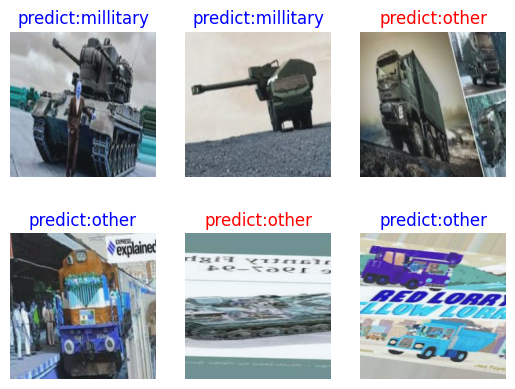

In [16]:
import matplotlib.pyplot as plt
import numpy as np
data = next(dataset_val.create_dict_iterator())
images = data["image"]
labels = data["label"]
output = network(data['image'])
pred = np.argmax(output.asnumpy(), axis=1)

# 图像分类
classes = ["millitary", "other"]

# 显示图像及图像的预测值
plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    # 若预测正确，显示为蓝色；若预测错误，显示为红色
    color = 'blue' if pred[i] == labels.asnumpy()[i] else 'red'
    plt.title('predict:{}'.format(classes[pred[i]]), color=color)
    picture_show = np.transpose(images.asnumpy()[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    picture_show = std * picture_show + mean
    picture_show = np.clip(picture_show, 0, 1)
    plt.imshow(picture_show)
    plt.axis('off')

plt.show()

## 总结

本案例完成了一个ViT模型在包含军车和其他车辆的数据集上进行训练，验证和推理的过程，其中，对关键的ViT模型结构和原理作了讲解。通过学习本案例，理解源码可以帮助用户掌握Multi-Head Attention，TransformerEncoder，pos_embedding等关键概念，如果要详细理解ViT的模型原理，建议基于源码更深层次的详细阅读。